# Experiments: "Reduced Data-Driven Turbulence Closure for Capturing Long-Term Statistics"

This notebook takes the user through the main experiment in the paper "Reduced Data-Driven Turbulence Closure for Capturing Long-Term Statistics". We test multiple turbulence models on a large eddy simulation of 2D turbulence:
- The classic Smagorinsky model;
- A a-priori trained CNN model;
- The newly introduced tau-orthogonal method.

The last two methods are data-driven and use training data from a high-fidelity reference simulation to tune a subgrid model.

In [5]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json
import shutil
import pandas as pd
import seaborn as sns

## Download data
All data needed to run this notebook can be downloaded from https://data.mendeley.com/.
You can also generate this data yourself by executing the solvers. 

It is highly recommended to use the data in the pre_computed_data folder. This includes the data from a long reference simulation and training data obtained from this reference simulation. Recomputing this is computationally very expensive, if you decide you want this set "RUN_SIM_REF" to True.

Low-fidelity simulations are computationally much cheaper you can execute them locally by setting "SKIP_SOLVERS" to False.


In [6]:
# flag to skip all executions of the solvers 
RUN_SIM_REF = False
SKIP_SOLVERS = True

# create samples directory
if not os.path.exists("./output/samples"):
    os.makedirs("./output/samples")

# if SKIP_SOLVERS is True, copy the precomputed data to the output directory
if SKIP_SOLVERS:
    file_list = ["get_initial_conditions_t_300.0.hdf5", "LF_rk4_t_5000.0.hdf5", "LF_track_ref_rk4_t_500.0.hdf5","LF_TO_t_1000.0.hdf5", "LF_smag_t_1000.0.hdf5" ,"LF_CNN_t_500.0.hdf5"]
    for file in file_list:
        if not os.path.exists("output/samples/"+ file):
            shutil.copyfile('./pre_computed_data/samples/'+file, './output/samples/'+file)
    if not os.path.exists("output/CNN_models/CNN_1"):
        shutil.copytree('./pre_computed_data/CNN_models/CNN_1', './output/CNN_models/CNN_1')
        


In [7]:
# define function to calculate KS-distance between two empirical distributions
def ks_dist(data1,data2):
    if np.ma.is_masked(data1):
        data1 = data1.compressed()
    if np.ma.is_masked(data2):
        data2 = data2.compressed()
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    if min(n1, n2) == 0:
        raise ValueError('Data passed to ks_dist must not be empty')

    # create an array with all the data
    data_all = np.concatenate([data1, data2])
    # create cdfs
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2

    cddiffs = np.abs(cdf1 - cdf2)

    # Identify the location of the statistic
    argmaxS = np.argmax(cddiffs)
    loc_maxS = data_all[argmaxS]
    d_1 = cddiffs[argmaxS]

    return d_1, loc_maxS

## Initial conditions for restart
We will first run our HF solver for 300 days to get some initial conditions in the statistical steady state of the system.


In [8]:
if not SKIP_SOLVERS:
    os.system('python compute_reference.py inputs/in_get_initial_conditions.json')

Now we can plot the final field, which will be used as initial conditions for our experiments:

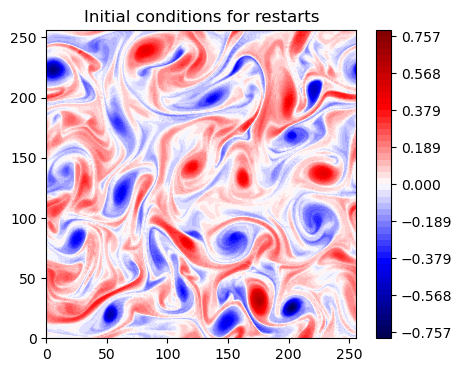

In [5]:
if os.path.exists("./output/restart/get_initial_conditions_t_300.0.hdf5"):
    file_loc = "./output/restart/get_initial_conditions_t_300.0.hdf5"
else:
    file_loc = "./pre_computed_data/restart/get_initial_conditions_t_300.0.hdf5"

with h5py.File(file_loc, "r") as f:
    w_hat = f["w_hat_n_HF"][:,:]
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams["figure.figsize"] = (5,4)
max_val = np.max(np.abs(np.fft.ifft2(w_hat).real))
levels = np.linspace(-max_val,max_val,51)
cb = plt.contourf(np.fft.ifft2(w_hat).real, levels)
plt.colorbar(cb)
plt.title("Initial conditions for restarts");

And we plot how our specified QoI converge to a steady state

<KeysViewHDF5 ['Q_HF', 'w_hat_n_HF_filtered']>


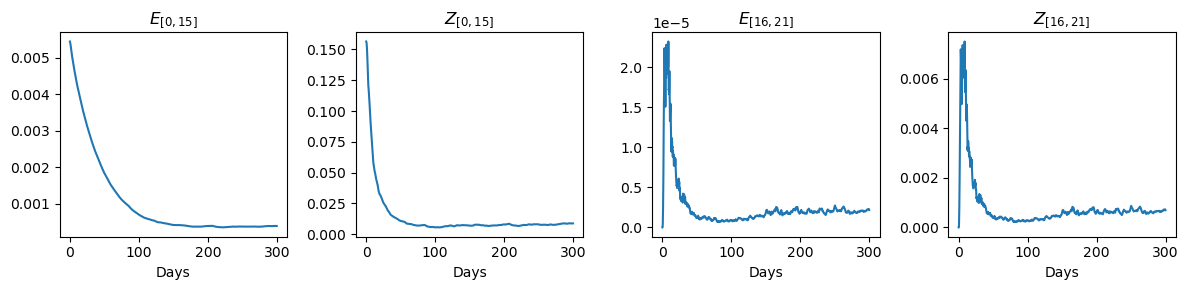

In [6]:
with h5py.File("./output/samples/get_initial_conditions_t_300.0.hdf5", "r") as f:
    print(f.keys())
    Q_HF = f["Q_HF"][:,:]
QoI_names = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
time_axis = np.arange(0, 300, 0.1)
for i in range(4):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.subplot(1,4,i+1)
    plt.plot(time_axis, Q_HF[:-1,i])
    plt.xlabel('Days')
    plt.title(QoI_names[i])
plt.tight_layout()

## Creating reference and training data
Reference and training data can be created using the following scripts. 

NOTE: running these simulations is computationally expensive, consider setting an appropriate simulation length in the input files.

The reference simulation and training data used in the paper can be found in "pre_computed_data".

In [7]:
# File names in this cell might need to be changed if one changes the simulation length (this is part of the file name)

if RUN_SIM_REF:
    # reference simulation
    os.system('python compute_reference.py inputs/in_get_training_data.json')
    file_ref = "./output/samples/train_data_sharp_t_3000.0.hdf5"
    file_train_sharp = "./output/train_data/train_data_sharp_t_3000.0.hdf5"
    # create training data from simulation using Gaussian filter in coarse graining
    os.system('python compute_reference.py inputs/in_get_training_data_gauss.json')
    file_train_gauss = "./output/train_data/train_data_gauss_t_3000.0.hdf5"
else:
    print("Get files from pre_computed_data")
    file_ref = "./pre_computed_data/ref/HF_20000days_RK4.hdf5"
    file_train_sharp = "./pre_computed_data/train_data_RK4/HF_sharp_3000.hdf5"
    file_train_gauss = "./pre_computed_data/train_data_RK4/HF_gauss_3000.hdf5"

Get files from pre_computed_data


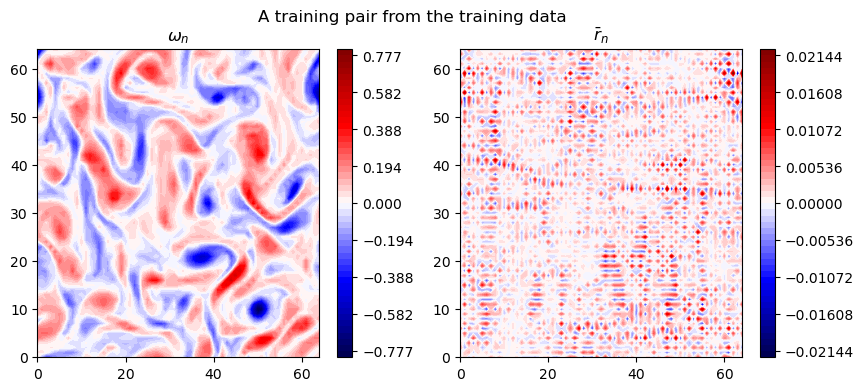

In [8]:
plt.rcParams["figure.figsize"] = (10,4)
with h5py.File(file_train_sharp, "r") as f:
    plt.subplot(1,2,1)
    max_val = np.max(np.abs(f["input_w_n"][10,:,:]))
    levels = np.linspace(-max_val,max_val,51)
    cb = plt.contourf(f["input_w_n"][10,:,:],levels)
    plt.colorbar(cb)
    plt.title(r"$\omega_n$")

    plt.subplot(1,2,2)
    max_val = np.max(np.abs(f["r_bar"][10,:,:]))
    levels = np.linspace(-max_val,max_val,51)
    cb = plt.contourf(f["r_bar"][10,:,:],levels)
    plt.colorbar(cb)
    plt.title(r"$\bar{r}_n$")
    plt.suptitle("A training pair from the training data")
    

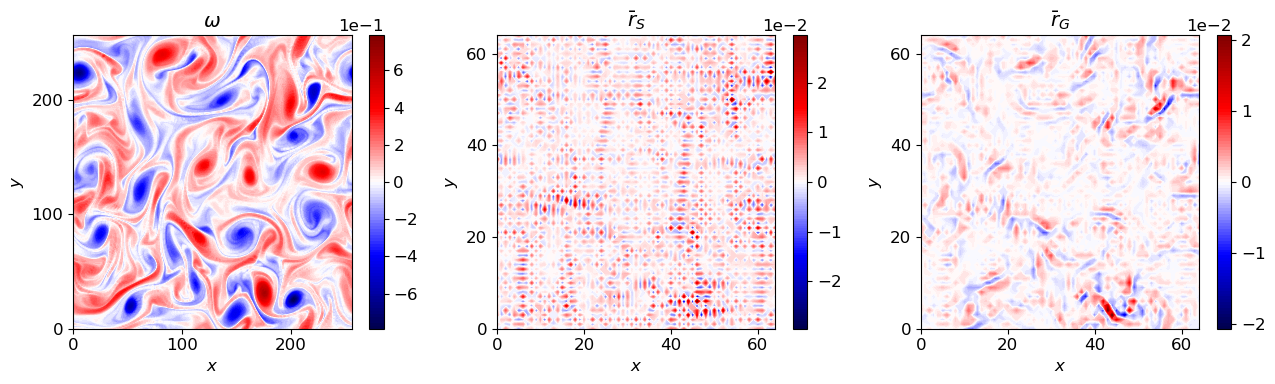

In [9]:
# plot of the effect of the 2 different filters
plt.rcParams.update({'font.size': 12})
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams["figure.figsize"] = (13,4)

plt.subplot(1,3,1)
with h5py.File('pre_computed_data/restart/get_initial_conditions_t_300.0.hdf5', 'r') as file:
    physical_field = np.fft.ifft2(file["w_hat_n_HF"][:,:]).real
    max_v = np.max(np.abs(physical_field))
    rc = plt.contourf(physical_field,100, levels=np.linspace(-max_v,max_v,101, endpoint=True))
    cb = plt.colorbar(ticks=[-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
    cb.formatter.set_powerlimits((0, 0))
    plt.yticks([0,100,200])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title(r"$\omega$")

plt.subplot(1,3,2)
with h5py.File(file_train_sharp, 'r') as file:
    max_v = np.max(file['r_bar'][0,:,:])
    rc = plt.contourf(file['r_bar'][0,:,:],100, levels=np.linspace(-max_v,max_v,121, endpoint=True))
    cb = plt.colorbar(ticks=[-0.03,-0.02,-0.01, -0.05, 0, 0.05, 0.01, 0.02, 0.03])
    cb.formatter.set_powerlimits((0, 0))
    plt.title(r"$\bar{r}_S$")
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.yticks([0,20,40,60])
plt.subplot(1,3,3)
with h5py.File(file_train_gauss, 'r') as file:
    max_v = np.max(file['r_bar'][0,:,:])
    rc = plt.contourf(file['r_bar'][0,:,:],100, levels=np.linspace(-max_v,max_v,101, endpoint=True))
    cb = plt.colorbar(ticks=[-0.02, -0.01, -0.05, 0, 0.05, 0.01, 0.02])
    cb.formatter.set_powerlimits((0, 0))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title(r"$\bar{r}_G$")
    plt.yticks([0,20,40,60])
plt.tight_layout()

#plt.savefig("figs/sgstendency_filters.png", dpi=700)

## Running a low-fidelity simulation
We will now run a low fidelity simulation without subgrid parameterization.

In [10]:
if not SKIP_SOLVERS:
    os.system("python LF_simulation.py inputs/in_LF.json")
file_LF = "./output/samples/LF_rk4_t_5000.0.hdf5"

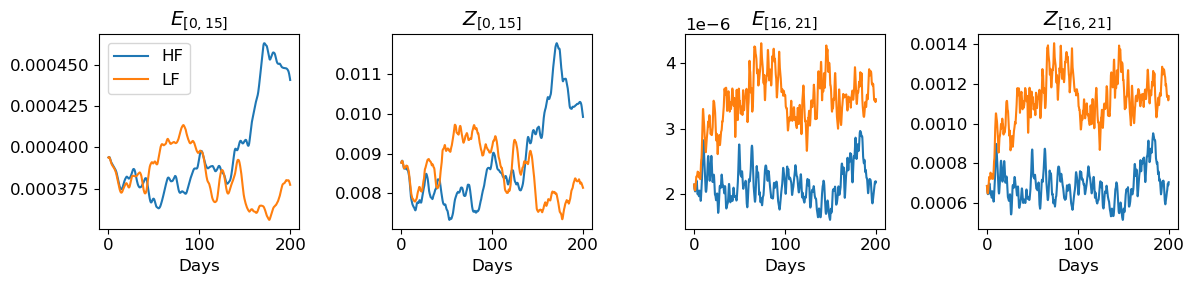

In [11]:
# plot the 4 qoi in LF and HF sim
with h5py.File(file_ref, "r") as f:
    Q_HF = f["Q_HF"][:,:]
with h5py.File(file_LF, "r") as f:
    Q_LF = f["Q_LF"][:,:]
QoI_names = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
time_LF = np.arange(0, 200, 0.1)

for i in range(4):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.subplot(1,4,i+1)
    plt.plot(time_LF, Q_HF[:2000,i], label = "HF")
    plt.plot(time_LF, Q_LF[:2000,i], label = "LF")
    plt.xlabel('Days')
    plt.title(QoI_names[i])
    if i==0: plt.legend()
plt.tight_layout()

## Tracking the high fidelity reference with a low fidelity simulation
We will now use the TO method to track the reference trajectories of the QoIs obtained with the high fidelity solver.

During this simulation the corrections ($\Delta Q$) made to the QoIs are saved. These will be used as training data for our "online" TO parameterizations.

In [20]:
if not SKIP_SOLVERS:
    os.system("python LF_simulation.py inputs/in_LF_track_ref.json")
file_track = "./output/samples/LF_track_ref_rk4_t_500.0.hdf5"

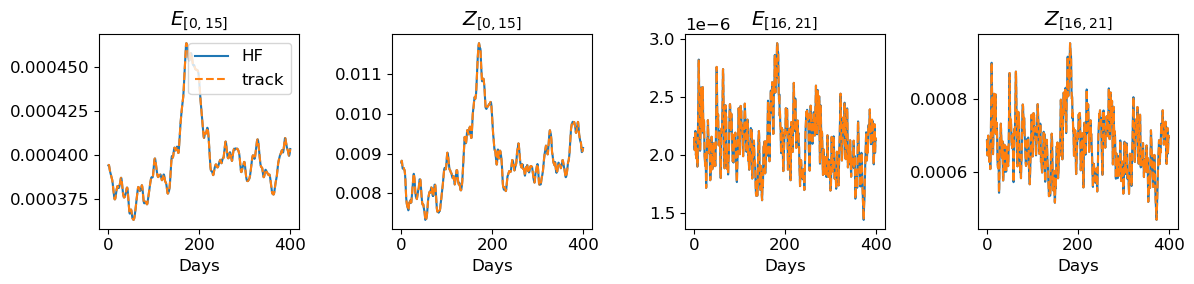

In [21]:
# plot the 4 qoi in LF and HF sim
with h5py.File(file_ref, "r") as f:
    Q_HF = f["Q_HF"][:,:]
with h5py.File(file_track, "r") as f:
    Q_LF = f["Q_LF"][:,:]
QoI_names = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
time_LF = np.arange(0, 400, 0.1)

for i in range(4):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.subplot(1,4,i+1)
    plt.plot(time_LF, Q_HF[:4000,i], label = "HF")
    plt.plot(time_LF, Q_LF[:4000,i],'--', label = "track")
    plt.xlabel('Days')
    plt.title(QoI_names[i])
    if i==0: plt.legend()
plt.tight_layout()

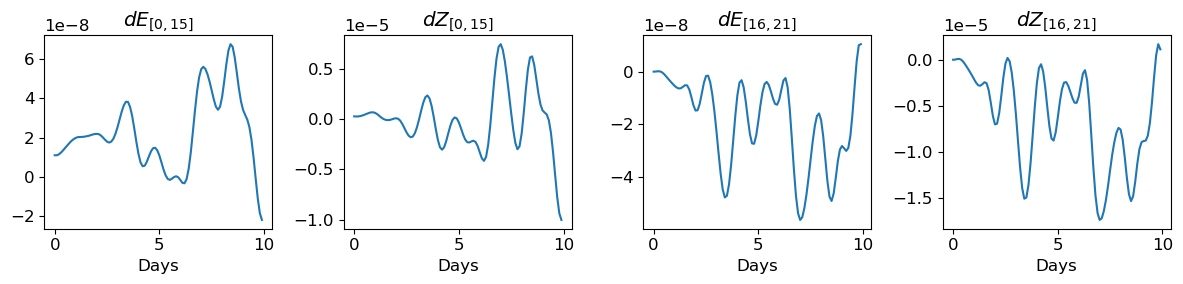

In [22]:
#plot dQs for illustration purposes
with h5py.File(file_track, "r") as f:
    dQ = f["dQ"][:,:]
QoI_names = ['$dE_{[0,15]}$','$dZ_{[0,15]}$','$dE_{[16,21]}$','$dZ_{[16,21]}$']
time_LF = np.arange(0, 10, 0.1)

for i in range(4):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.subplot(1,4,i+1)
    plt.plot(time_LF, dQ[:100,i])
    plt.xlabel('Days')
    plt.title(QoI_names[i])
plt.tight_layout()

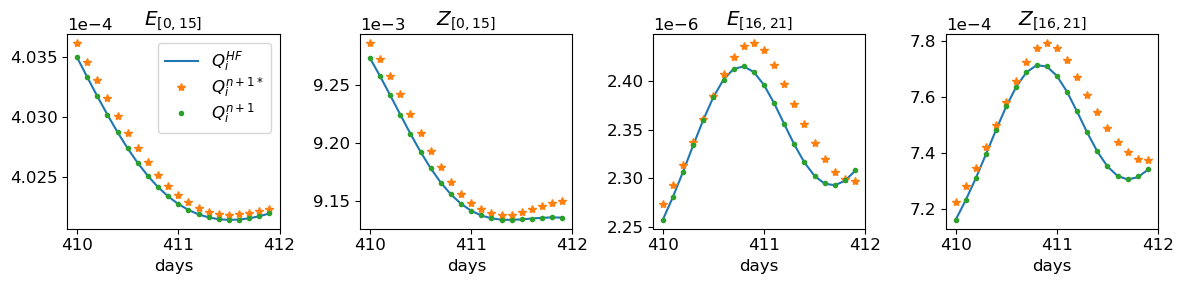

In [23]:
# plot correction process during tracking
plt.rcParams["figure.figsize"] = (12,3)
plt.rcParams.update({'font.size': 12})
QoI_names = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
d = 410
npoints = 20
time_LF = np.arange(0, npoints/10, 0.1)+d
b = d*10
for i in range(4):
    
    plt.subplot(1,4,i+1)
    plt.plot(time_LF, Q_HF[b:b+npoints,i], label = r"$Q_i^{HF}$")
    plt.plot(time_LF, Q_HF[b:b+npoints,i]-dQ[b:b+npoints,i],'*', label = r"$Q_i^{n+1 *}$")
    plt.plot(time_LF, Q_LF[b:b+npoints,i],'.', label = r"$Q_i^{n+1}$")
    plt.xlabel('days')
    plt.title(QoI_names[i])
    if i==0: plt.legend(labelspacing = 0.1, loc = 'upper right')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks([d, d+1, d+2])
plt.tight_layout()
#plt.savefig("figs/LF_tracking.pdf", bbox_inches = 'tight')

## Train and run online parameterizations

### Train and run a CNN

In [16]:
from aux_code.CNN_trainer import train_new_CNN

train_file = file_train_gauss
model_dir = "output/CNN_models/CNN_1"
hist_file = model_dir + "/history.json"

if not SKIP_SOLVERS:
    train_new_CNN(train_file, model_dir, hist_file, n_train_samples=1000, target='r_bar', n_epochs=100, add_rotations = False)

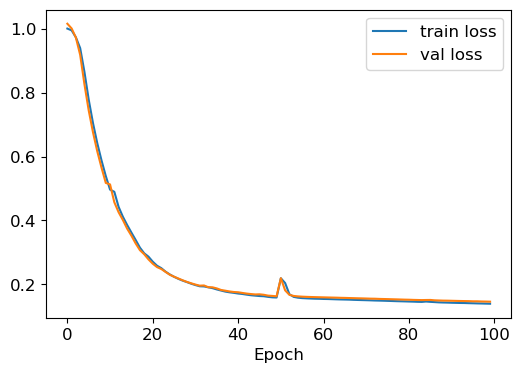

In [17]:
# plot loss
with open(hist_file) as f:
    hist = json.load(f)
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(hist['train_loss'], label='train loss')
plt.plot(hist['test_loss'], label='val loss')
plt.xlabel('Epoch')
plt.legend()

In [18]:
if not SKIP_SOLVERS:
    os.system("python LF_simulation.py inputs/in_LF_CNN_base.json")

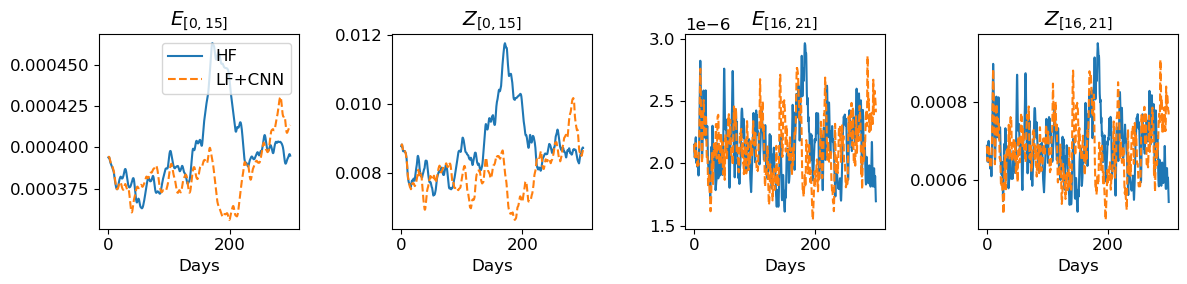

In [19]:
fname_cnn = "./output/samples/LF_CNN_t_500.0.hdf5"

# plot the 4 qoi in LF and HF sim
with h5py.File(file_ref, "r") as f:
    Q_HF = f["Q_HF"][:,:]
with h5py.File(fname_cnn, "r") as f:
    Q_LF = f["Q_LF"][:,:]
QoI_names = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
n_days = 300
time_LF = np.arange(0, n_days, 0.1)

for i in range(4):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.subplot(1,4,i+1)
    plt.plot(time_LF, Q_HF[:n_days*10,i], label = "HF")
    plt.plot(time_LF, Q_LF[:n_days*10,i],'--', label = "LF+CNN")
    plt.xlabel('Days')
    plt.title(QoI_names[i])
    if i==0: plt.legend()
plt.tight_layout()

### Train and run TO
We perform a simulation with online TO parametrization which samples from a multivariate gaussian (MVG). The MVG is fitted to the data from days 200-1000.

In [20]:
if not SKIP_SOLVERS:
    os.system("python LF_simulation.py inputs/in_LF_TO_base.json")

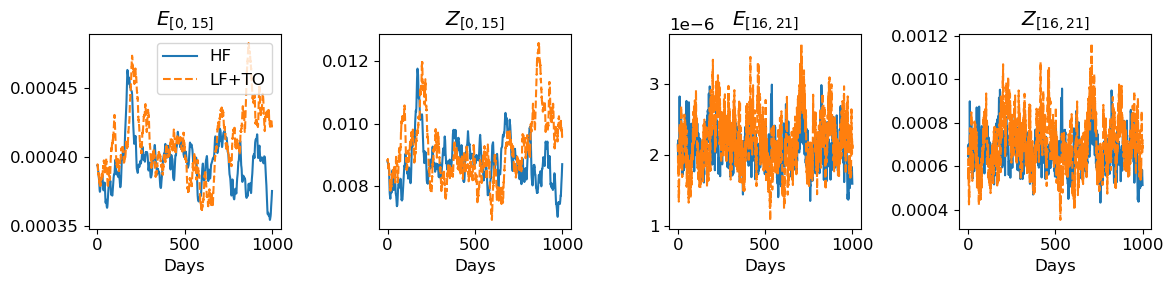

In [21]:
# plot the 4 qoi in LF and HF sim
with h5py.File(file_ref, "r") as f:
    Q_HF = f["Q_HF"][:,:]
with h5py.File("./output/samples/LF_TO_t_1000.0.hdf5", "r") as f:
    Q_LF = f["Q_LF"][:,:]
QoI_names = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
time_LF = np.arange(0, 1000, 0.1)

for i in range(4):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.subplot(1,4,i+1)
    plt.plot(time_LF, Q_HF[:10000,i], label = "HF")
    plt.plot(time_LF, Q_LF[:10000,i],'--', label = "LF+TO")
    plt.xlabel('Days')
    plt.title(QoI_names[i])
    if i==0: plt.legend()
plt.tight_layout()

## Smagorinsky parametrization
We show how to use the Smagorinsky parametrization

In [22]:
if not SKIP_SOLVERS:
    os.system("python LF_simulation.py inputs/in_LF_smag.json")

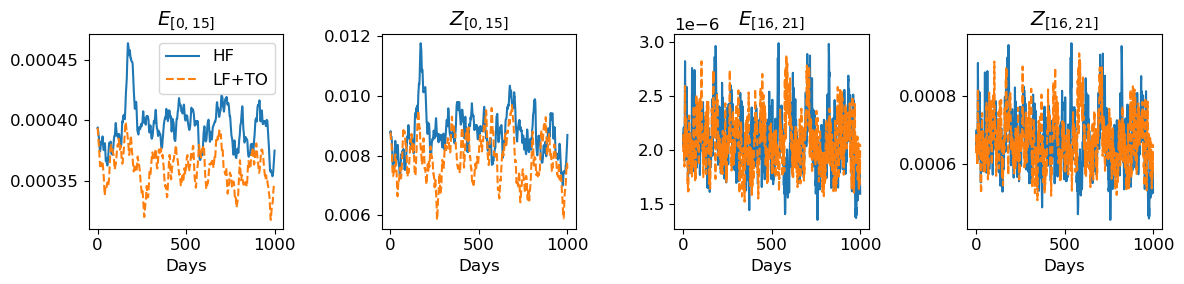

In [23]:
# plot the 4 qoi in LF and HF sim
with h5py.File(file_ref, "r") as f:
    Q_HF = f["Q_HF"][:,:]
with h5py.File("./output/samples/LF_smag_t_1000.0.hdf5", "r") as f:
    Q_LF = f["Q_LF"][:,:]
QoI_names = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
time_LF = np.arange(0, 1000, 0.1)

for i in range(4):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.subplot(1,4,i+1)
    plt.plot(time_LF, Q_HF[:10000,i], label = "HF")
    plt.plot(time_LF, Q_LF[:10000,i],'--', label = "LF+TO")
    plt.xlabel('Days')
    plt.title(QoI_names[i])
    if i==0: plt.legend()
plt.tight_layout()

# Performing the experiment
Finally, we show how to setup an experiment as presented in the paper. This involves parameter searches for all 3 parameterizations. We provide code to setup the searches, post-process results and plot the results. 

Note that running the grid searches is computationally expensive. Also sharing the direct results of the runs performed in the grid searches would involve fast amounts of data. We therefore only provide the post-processed results in the folder "pre_computed_data".

To visualize results from individual runs, this includes all probability density kernels in the report and the plots in the section "Other widely used metrics", the raw output of the grid searches is needed. For the "best" runs we provide the raw output files, such that their results can be plotted.

## Setup of gridsearch
- For the grid search we will create a set of input files with parameter settings we want to test
- Then we call the solver on each of these inputs (this can be done in parallel when you have access to multiple GPUs)

We perform the following grid searches
> Smagorinsky:
- $C_s \in [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.16, 0.18, 0.2]$
- Total: 14 runs
> CNN:
- Train size $\in [100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000]$
- Filter $\in [\text{Gauss}, \text{Sharp}]$
- Total: $8*2=16$ setups, each setup 10 runs. 
> TO:
- Train size $\in [100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000]$
- Sampling method $\in [\text{MVG}, \text{independent sampling}, \text{resampling}]$
- Total: $8*3=24$ setups, each setup 10 runs.

In [9]:
from aux_code.read_inputs import adapt_input_file

In [11]:
# create input files for gridsearch
if not os.path.exists("inputs/gridsearch/smag"):
    os.makedirs("inputs/gridsearch/smag")
if not os.path.exists("inputs/gridsearch/TO"):
    os.makedirs("inputs/gridsearch/TO")
if not os.path.exists("inputs/gridsearch/CNN"):
    os.makedirs("inputs/gridsearch/CNN")
if not os.path.exists("output/samples/gridsearch"):
    os.makedirs("output/samples/gridsearch")

sim_time = 5000 # length of the simulation
n_epochs = 100  # number of epochs for training the CNN

# create files for smag
C_s_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.16, 0.18, 0.2]
for i, C_s in enumerate(C_s_list):
    new_flags = {"sim_ID": "gridsearch/Cs_"+str(C_s),
                 "smag_constant": C_s,
                 "simulation_time": sim_time}
    adapt_input_file("inputs/in_LF_smag.json", "inputs/gridsearch/smag/in_smag_"+str(i+1)+".json", new_flags)
   
# create files for TO
train_size = [100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000]
sampling_method = ["MVG", "indep", "resample"]
i = 0
for s in sampling_method:
    i_inner = 0
    for t in train_size:
        i+=1; i_inner+=1
        new_flags = {"sim_ID": "gridsearch/TO_"+s+"_"+str(t),
                     "sample_domain": [2000, 2000+t*10, 1],
                     "sample_independent": s=="indep",
                     "use_MVG": s=="MVG",
                     "simulation_time": sim_time}
        adapt_input_file("inputs/in_LF_TO_base.json", "inputs/gridsearch/TO/in_TO_"+str(i)+".json", new_flags)

# create files for CNN
train_size = [100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000]
filters = ["gauss", "sharp"]
add_rotations = True

i = 0

for f in filters:
    i_inner = 0
    for t in train_size:
        i+=1; i_inner+=1
        # create an input file for training the CNN
        input_dict = {"CNN_id": i,
                        "model_dir": "output/CNN_models_temp/CNN_"+str(i),
                        "train_file": "pre_computed_data/train_data_RK4/HF_"+f+"_5000.hdf5",
                        "hist_directory": "output/CNN_models_hist",
                        "n_train_samples": t,
                        "n_epochs": n_epochs,
                        "add_rotations": add_rotations}
        with open("inputs/gridsearch/CNN/in_trainer_"+str(i)+".json", "w") as fp:
            json.dump(input_dict, fp)
        
        # input file for LF simulation
        new_flags = {"sim_ID": "gridsearch/CNN_"+f+"_"+str(t),
                        "use_gaussian_filter": f=="gauss",
                        "discretization_SGS_term": 1,
                        "parametrization_file_path": "output/CNN_models_temp/CNN_"+str(i),
                        "simulation_time": sim_time}
        adapt_input_file("inputs/in_LF_CNN_base.json", "inputs/gridsearch/CNN/in_CNN_"+str(i)+".json", new_flags)

## Running gridsearch simulations
Now that we have all input files, we need to run all the simulations. This is the moment where access to a super-computer might come in handy, because running all these simulations on a single GPU might take 2 weeks.

We provide the SLURM jobfiles we used in the folder "job_scripts".

# Post processing of gridsearch results
We create a Pandas dataframe which contains the KS-distance of the long term distributions of the QoIs in LF simulations with respect to the reference distribution from a HF simulation. 

In [14]:
# read the data from the gridsearch
ref_file = "./pre_computed_data/ref/HF_20000days_RK4.hdf5"
df = pd.DataFrame(columns=["method","filter","train_length","sampling_approach", "c_s", "SGS_discr", "test_corr", "run"])
file_end = "_t_5000.0.hdf5"

with h5py.File(ref_file) as file: #load reference data
    refdata = file["Q_HF"][:2000000,:]

# first read in the data from the run of the LF solver without any parametrization
file_name = 'output/samples/LF_rk4_t_5000.0.hdf5'
ks = np.zeros(4)
if os.path.exists(file_name):
    with h5py.File(file_name) as file:
        data = file["Q_LF"][:,:]
    for qoi in [0,1,2,3]:
        d,_ = ks_dist(data[:,qoi],refdata[:,qoi])
        ks[qoi] = d

    entry = pd.DataFrame.from_dict({
                                    "method": ['none'],
                                    "filter": ["sharp"],
                                    "ks_0" : ks[0],
                                    "ks_1" : ks[1],
                                    "ks_2" : ks[2],
                                    "ks_3" : ks[3]
                                })
    df = pd.concat([df, entry], ignore_index=True)
else:
    print("No data found for LF solver without parametrization")

#read data from Smagorinsky runs
print("Reading data from Smagorinsky runs")
n_setups = 14
C_s_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.16, 0.18, 0.2]

for i in range(n_setups):
    print(f"Reading data for setup {i+1} of {n_setups}")
    file_name = f'output/samples/gridsearch/Cs_{C_s_list[i]}'+"_t_5000.0.hdf5"
    if os.path.exists(file_name):
        with h5py.File(file_name) as file:
            data = file["Q_LF"][:,:]
        for qoi in [0,1,2,3]:
            d,_ = ks_dist(data[:,qoi],refdata[:,qoi])
            ks[qoi] = d

        entry = pd.DataFrame.from_dict({
                                        "method": ['Smag'],
                                        "filter": ["sharp"],
                                        "c_s" : C_s_list[i],
                                        "SGS_discr":[1],
                                        "ks_0" : ks[0],
                                        "ks_1" : ks[1],
                                        "ks_2" : ks[2],
                                        "ks_3" : ks[3]
                                    })
        df = pd.concat([df, entry], ignore_index=True)
    else:
        print(f"No data found for LF solver with smag parametrization, C_s = {C_s_list[i]}")
        print(file_name)
    

# read data from TO runs
print("Reading data from TO runs")
n_runs = 10
n_setups = 30
train_size = [100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000]
sampling_method = ["MVG", "indep", "resample"]
i=0
for s in sampling_method:
    for t in train_size:
        i+=1
        print(f"Reading data for setup {i} of {n_setups}")
        for run in range(1,n_runs+1):
            file_name = 'output/samples/gridsearch/TO_'+s+'_'+str(t)+'_run_'+str(run)+file_end
            if os.path.exists(file_name):
                with h5py.File(file_name) as file:
                    data = file["Q_LF"][:,:]
                for qoi in [0,1,2,3]:
                    d,_ = ks_dist(data[:,qoi],refdata[:,qoi])
                    ks[qoi] = d

                entry = pd.DataFrame.from_dict({
                                                "method": ['TO'],
                                                "sampling_approach": [s],
                                                "train_length": [t],
                                                "filter": ["sharp"],
                                                "ks_0" : ks[0],
                                                "ks_1" : ks[1],
                                                "ks_2" : ks[2],
                                                "ks_3" : ks[3],
                                                "run": [run]
                                            })
                df = pd.concat([df, entry], ignore_index=True)
            else:
                print(f"No data found for LF solver with TO parametrization, sampling method = {s}, train size = {t}, run = {run}")

# read data from CNN runs

print("Reading data from CNN runs")
n_runs = 10
n_setups = 16
train_size = [100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000]
filters = ["gauss", "sharp"]
add_rotations = [True]*2
i=0

for f in filters:
    for t in train_size:
        i+=1
        print(f"Reading data for setup {i} of {n_setups}")
        for run in range(1,n_runs+1):
            file_name = 'output/samples/gridsearch/CNN_'+f+"_"+str(t)+'_run_'+str(run)+file_end
            if os.path.exists(file_name):
                with h5py.File(file_name) as file:
                    data = file["Q_LF"][:,:]
                for qoi in [0,1,2,3]:
                    d,_ = ks_dist(data[:,qoi],refdata[:,qoi])
                    ks[qoi] = d
                hist_file = f"output/CNN_models_hist/hist_CNN_{i}_run_{run}.json"
                with open(hist_file,'r') as file:
                    hist = json.load(file)
                    test_corr = hist['test_corr'][-1]
                entry = pd.DataFrame.from_dict({
                                                "method": ['CNN'],
                                                "train_length": [t],
                                                "filter": [f],
                                                "SGS_discr": [1],
                                                "ks_0" : ks[0],
                                                "ks_1" : ks[1],
                                                "ks_2" : ks[2],
                                                "ks_3" : ks[3],
                                                "test_corr": [test_corr],
                                                "run": [run]
                                            })
                df = pd.concat([df, entry], ignore_index=True)
            else:
                print(f"No data found for LF solver with CNN parametrization, filter = {f}, train size = {t}, run = {run}")



Reading data from Smagorinsky runs
Reading data for setup 1 of 14
Reading data for setup 2 of 14
Reading data for setup 3 of 14
Reading data for setup 4 of 14
Reading data for setup 5 of 14
Reading data for setup 6 of 14
Reading data for setup 7 of 14
Reading data for setup 8 of 14
Reading data for setup 9 of 14
Reading data for setup 10 of 14
Reading data for setup 11 of 14
Reading data for setup 12 of 14
Reading data for setup 13 of 14
Reading data for setup 14 of 14
Reading data from TO runs
Reading data for setup 1 of 30
Reading data for setup 2 of 30
Reading data for setup 3 of 30
Reading data for setup 4 of 30
Reading data for setup 5 of 30
Reading data for setup 6 of 30
Reading data for setup 7 of 30
Reading data for setup 8 of 30
Reading data for setup 9 of 30
Reading data for setup 10 of 30
Reading data for setup 11 of 30
Reading data for setup 12 of 30
Reading data for setup 13 of 30
Reading data for setup 14 of 30
Reading data for setup 15 of 30
Reading data for setup 16 of 

In [6]:
df.head()

,method,filter,train_length,sampling_approach,c_s,SGS_discr,test_corr,run,ks_0,ks_1,ks_2,ks_3
0,none,sharp,NaN,NaN,NaN,NaN,NaN,NaN,0.124180,0.082257,0.983405,0.988315
1,TO,sharp,100,MVG,NaN,NaN,NaN,1,0.055505,0.043132,0.079186,0.077421
2,TO,sharp,100,MVG,NaN,NaN,NaN,2,0.044688,0.054884,0.076050,0.072190
3,TO,sharp,100,MVG,NaN,NaN,NaN,3,0.170794,0.117161,0.063277,0.077191
4,TO,sharp,100,MVG,NaN,NaN,NaN,4,0.050425,0.030962,0.065961,0.065807


In [15]:
df.to_csv("output/gridsearch_results_rk4.csv", index=False)

## Plot gridsearch results

In [29]:
# load df from pre_computed_data
df = pd.read_csv("pre_computed_data/gridsearch_results_rk4.csv")

In [30]:
# the data frame contains ks-distances wrt the HF ref solution for all LF simulations.
df.head(10)
# the first row should correspond to a LF simulation without SGS model

,method,filter,train_length,sampling_approach,c_s,SGS_discr,test_corr,run,ks_0,ks_1,ks_2,ks_3
0,none,sharp,NaN,NaN,NaN,NaN,NaN,NaN,0.124180,0.082257,0.983405,0.988315
1,Smag,sharp,NaN,NaN,0.01,1.0,NaN,NaN,0.202343,0.048864,0.981940,0.987605
2,Smag,sharp,NaN,NaN,0.02,1.0,NaN,NaN,0.223259,0.033627,0.967745,0.977800
3,Smag,sharp,NaN,NaN,0.03,1.0,NaN,NaN,0.226146,0.035003,0.957145,0.969375
4,Smag,sharp,NaN,NaN,0.04,1.0,NaN,NaN,0.221274,0.054337,0.919191,0.938146
5,Smag,sharp,NaN,NaN,0.05,1.0,NaN,NaN,0.206566,0.019849,0.856157,0.883691
6,Smag,sharp,NaN,NaN,0.07,1.0,NaN,NaN,0.342488,0.098116,0.601745,0.642369
7,Smag,sharp,NaN,NaN,0.08,1.0,NaN,NaN,0.422769,0.182221,0.423122,0.461991
8,Smag,sharp,NaN,NaN,0.09,1.0,NaN,NaN,0.539371,0.264270,0.202324,0.236919
9,Smag,sharp,NaN,NaN,0.10,1.0,NaN,NaN,0.595005,0.300403,0.040459,0.036583


### CNN plots

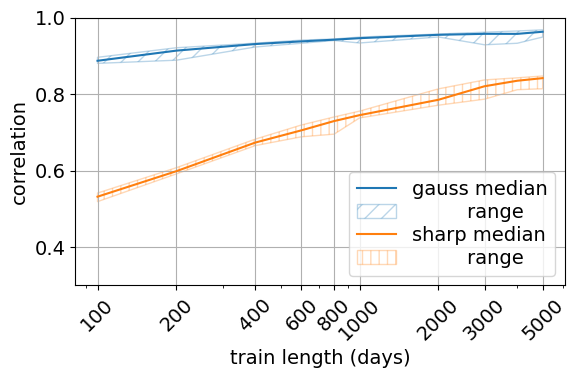

In [17]:
# Plot the performance of the CNNs on the withheld test data
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (6,4)
fig, ax = plt.subplots(1,1)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ks_list = ["ks_0", "ks_1", "ks_2", "ks_3"]
hatches = ['//', '||', 'O']

s_i = 0
filters = ["gauss", "sharp"]
for filter in filters:
    dd = df[(df["filter"]==filter)&(df["method"]=="CNN")].copy()
    
    dd['ks_sum'] = dd['ks_0'] + dd['ks_1'] + dd['ks_2'] + dd['ks_3']

    mean_df = dd.groupby('train_length')[['test_corr']].median()
    min_df = dd.groupby('train_length')[['test_corr']].min()
    max_df = dd.groupby('train_length')[['test_corr']].max()
   
    mean_df.plot(y='test_corr', ax=ax, label=filter+" median", color = prop_cycle[s_i])
    ax.fill_between(min_df.index, min_df['test_corr'], max_df['test_corr'], facecolor = (1,1,1), hatch = hatches[s_i], alpha=0.3, edgecolor = prop_cycle[s_i], label="         range")
    s_i+=1

ax.set_xlabel("train length (days)")
ax.set_ylabel("correlation")
ax.set_xscale('log')
tl = [100,200,400, 600, 800, 1000, 2000, 3000, 5000]
ax.set_xticks(tl,labels=tl, rotation = 45)
ax.set_ylim([0.3,1])
ax.grid()

ax.legend(labelspacing = 0.2)
    #ax[i//2,i%2].set_rasterized(True)

plt.tight_layout()
#plt.savefig('./figs/test_corr_offline_cnn.pdf', bbox_inches='tight')

In [18]:
# We compute the KS-distance between a 5000-day high-fidelity simulation and the 20000-day reference simulation
DNS_vals = []
t_short = 50000
with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file: #load reference data
    refdata = file["Q_HF"][:200000,:]
for i in range(4):
    d,_ = ks_dist(refdata[:t_short,i],refdata[:,i])
    DNS_vals.append(d)
print(DNS_vals, refdata.shape)

[0.025424999999999975, 0.01633499999999999, 0.013944999999999985, 0.014530000000000043] (200000, 4)


c:\Users\rik\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
c:\Users\rik\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


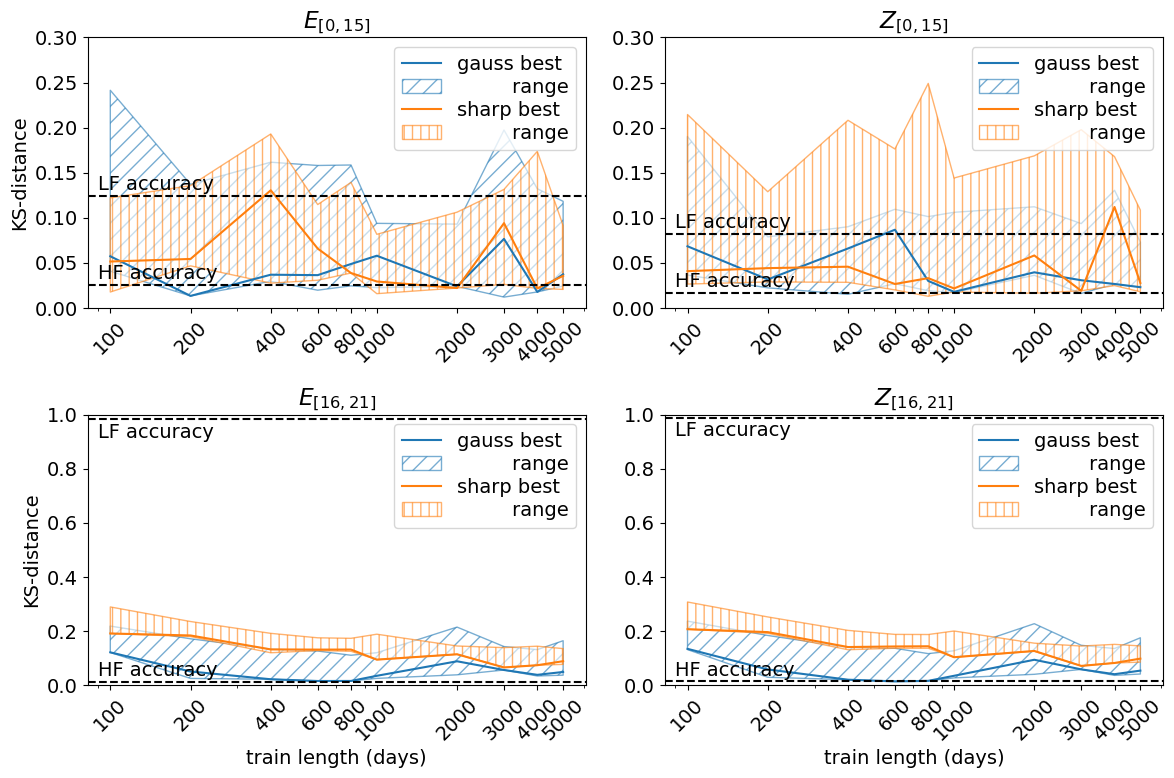

In [20]:
# Plot the performance of LF simulations with CNN parametrization

titles = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots(2,2)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ks_list = ["ks_0", "ks_1", "ks_2", "ks_3"]
hatches = ['//', '||', 'O']
s_i = 0

filters = ["gauss", "sharp"]
for f in filters:
    dd = df[(df["filter"]==f)&(df['method']=="CNN")].copy()
    dd['sum'] = dd['ks_0'] + dd['ks_1'] + dd['ks_2'] + dd['ks_3']
    indx = dd.groupby('train_length')['sum'].idxmin()
    best_df = dd.loc[indx]
    median_df = dd.groupby('train_length')[['ks_0','ks_1','ks_2', 'ks_3']].median()
    min_df = dd.groupby('train_length')[['ks_0','ks_1','ks_2', 'ks_3']].min()
    max_df = dd.groupby('train_length')[['ks_0','ks_1','ks_2', 'ks_3']].max()
    for i in [0,1,2,3]:
        best_df.plot(x= 'train_length',y=ks_list[i], ax=ax[i//2,i%2], label=f+" best", color = prop_cycle[s_i])
        #min_df.plot(y=ks_list[i],style='--' ,ax=ax[i//2,i%2] ,label=sampling_approach, color = prop_cycle[s_i])
        #max_df.plot(y=ks_list[i],style='-.' ,ax=ax ,label=sampling_approach, color = prop_cycle[s_i])
        ax[i//2,i%2].fill_between(min_df.index, min_df[ks_list[i]], max_df[ks_list[i]], facecolor = (1,1,1),
                                   hatch = hatches[s_i], alpha=0.6, edgecolor = prop_cycle[s_i], label="         range")
        ax[i//2,i%2].set_xlabel("")
        #plt.legend(labelspacing = 0.2)
    
    s_i+=1


s_i+=1

LES_vals = list(df.iloc[0][["ks_0","ks_1","ks_2","ks_3"]])
for i in [0,1,2,3]:
    ax[i//2,i%2].set_title(titles[i])
    if i>1:
        ax[i//2,i%2].set_xlabel("train length (days)")
    if i%2==0:
        ax[i//2,i%2].set_ylabel("KS-distance")
    ax[i//2,i%2].set_xscale('log')
    tl = [100,200,400, 600, 800, 1000, 2000, 3000, 4000, 5000]
    
    ax[i//2,i%2].set_xticks(tl, labels=tl, rotation = 45)
    if i==0: 
        ax[i//2,i%2].set_ylim([0,0.3]) 
        ax[i//2,i%2].annotate('LF accuracy', xy=(90, LES_vals[i]+0.007), color='black')
        ax[i//2,i%2].annotate('HF accuracy', xy=(90, DNS_vals[i]+0.007), color='black')
    elif i==1: 
        ax[i//2,i%2].set_ylim([0,0.3])
        ax[i//2,i%2].annotate('LF accuracy', xy=(90, LES_vals[i]+0.007), color='black')
        ax[i//2,i%2].annotate('HF accuracy', xy=(90, DNS_vals[i]+0.007), color='black')
    else: 
        ax[i//2,i%2].set_ylim([0,1])
        ax[i//2,i%2].annotate('LF accuracy', xy=(90, LES_vals[i]-0.069), color='black')
        ax[i//2,i%2].annotate('HF accuracy', xy=(90, DNS_vals[i]+0.02), color='black')
    ax[i//2,i%2].axhline(y=LES_vals[i], color='black', linestyle='--')
    ax[i//2,i%2].axhline(y=DNS_vals[i], color='black', linestyle='--')
    
    
    ax[i//2,i%2].legend(loc='upper right', labelspacing = 0.2)
    #ax[i//2,i%2].set_rasterized(True)

plt.tight_layout()

#plt.savefig('figs/KS_online_CNN.pdf', bbox_inches='tight')


c:\Users\rik\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
c:\Users\rik\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
c:\Users\rik\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


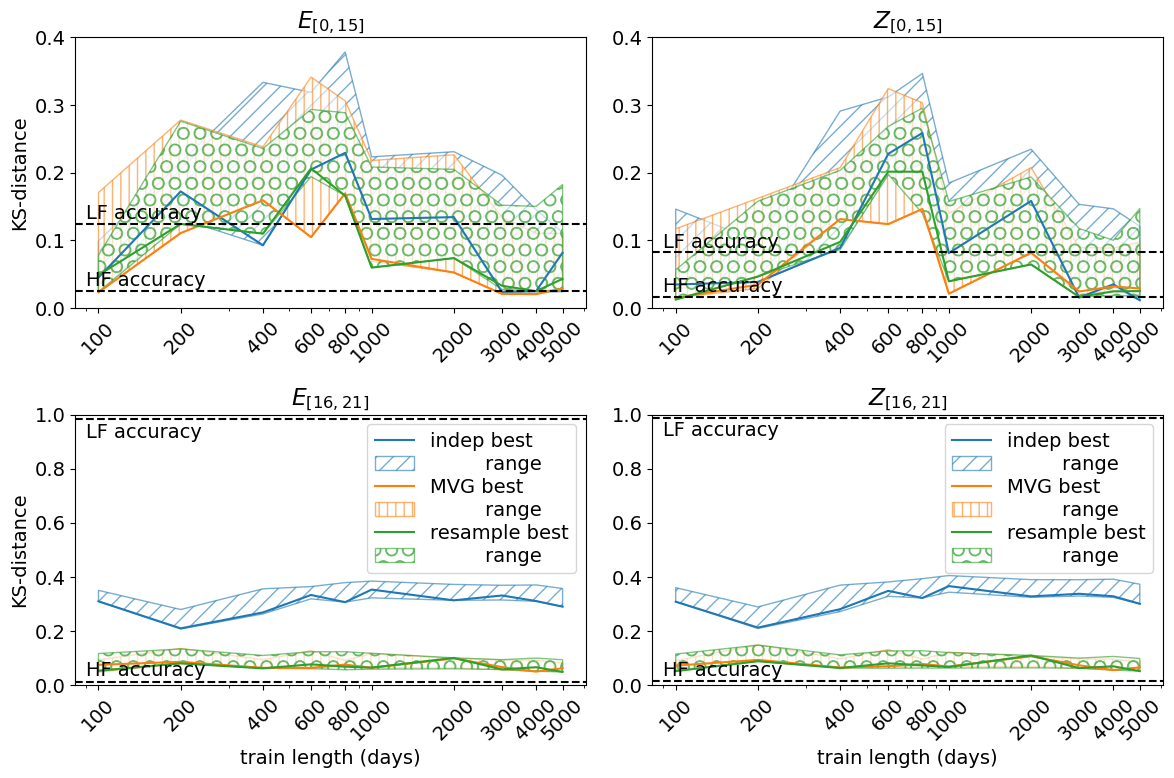

In [21]:
# Plot the performance of LF simulations with TO parametrization
titles = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots(2,2)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ks_list = ["ks_0", "ks_1", "ks_2", "ks_3"]
hatches = ['//', '||', 'O']
s_i = 0

sample = ["indep", "MVG", "resample"]
for s in sample:
    dd = df[(df["sampling_approach"]==s)&(df['method']=="TO")].copy()
    dd['sum'] = dd['ks_0'] + dd['ks_1'] + dd['ks_2'] + dd['ks_3']
    indx = dd.groupby('train_length')['sum'].idxmin()
    best_df = dd.loc[indx]
    median_df = dd.groupby('train_length')[['ks_0','ks_1','ks_2', 'ks_3']].median()
    min_df = dd.groupby('train_length')[['ks_0','ks_1','ks_2', 'ks_3']].min()
    max_df = dd.groupby('train_length')[['ks_0','ks_1','ks_2', 'ks_3']].max()
    for i in [0,1,2,3]:
        best_df.plot(x= 'train_length',y=ks_list[i], ax=ax[i//2,i%2], label=s+" best", color = prop_cycle[s_i])
        ax[i//2,i%2].fill_between(min_df.index, min_df[ks_list[i]], max_df[ks_list[i]], facecolor = (1,1,1),
                                   hatch = hatches[s_i], alpha=0.6, edgecolor = prop_cycle[s_i], label="         range")
        ax[i//2,i%2].set_xlabel("")
        #plt.legend(labelspacing = 0.2)
    
    s_i+=1


s_i+=1

LES_vals = list(df.iloc[0][["ks_0","ks_1","ks_2","ks_3"]])

for i in [0,1,2,3]:
    ax[i//2,i%2].set_title(titles[i])
    if i>1:
        ax[i//2,i%2].set_xlabel("train length (days)")
    if i%2==0:
        ax[i//2,i%2].set_ylabel("KS-distance")
    ax[i//2,i%2].set_xscale('log')
    tl = [100,200,400, 600, 800, 1000, 2000, 3000, 4000, 5000]
    
    ax[i//2,i%2].set_xticks(tl, labels=tl, rotation = 45)
    if i==0: 
        ax[i//2,i%2].set_ylim([0,0.4]) 
        ax[i//2,i%2].annotate('LF accuracy', xy=(90, LES_vals[i]+0.007), color='black')
        ax[i//2,i%2].annotate('HF accuracy', xy=(90, DNS_vals[i]+0.007), color='black')
        ax[i//2,i%2].legend().remove()
    elif i==1: 
        ax[i//2,i%2].set_ylim([0,0.4])
        ax[i//2,i%2].annotate('LF accuracy', xy=(90, LES_vals[i]+0.007), color='black')
        ax[i//2,i%2].annotate('HF accuracy', xy=(90, DNS_vals[i]+0.007), color='black')
        ax[i//2,i%2].legend().remove()
    else: 
        ax[i//2,i%2].set_ylim([0,1])
        ax[i//2,i%2].annotate('LF accuracy', xy=(90, LES_vals[i]-0.069), color='black')
        ax[i//2,i%2].annotate('HF accuracy', xy=(90, DNS_vals[i]+0.02), color='black')
        ax[i//2,i%2].legend(loc='upper right', labelspacing = 0.2)
    ax[i//2,i%2].axhline(y=LES_vals[i], color='black', linestyle='--')
    ax[i//2,i%2].axhline(y=DNS_vals[i], color='black', linestyle='--')
    
    
    
    #ax[i//2,i%2].set_rasterized(True)

plt.tight_layout()
#plt.savefig('figs/KS_online_TO.pdf', bbox_inches='tight')


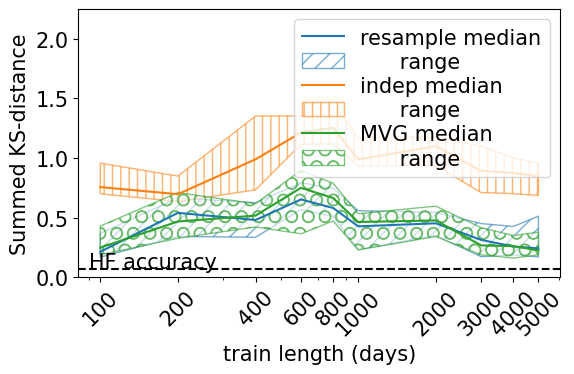

In [14]:
# plot the summed KS-distance for the TO parametrizations
titles = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (6,4)
fig, ax = plt.subplots(1,1)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ks_list = ["ks_0", "ks_1", "ks_2", "ks_3"]
hatches = ['//', '||', 'O']

s_i = 0

sample = ["resample", "indep", "MVG"]
for s in sample:
    dd = df[(df["sampling_approach"]==s)&(df['method']=="TO")].copy()
    dd['sum'] = dd['ks_0'] + dd['ks_1'] + dd['ks_2'] + dd['ks_3']
    
    df_median = dd.groupby('train_length')[['sum']].median()
    df_min = dd.groupby('train_length')[['sum']].min()
    df_max = dd.groupby('train_length')[['sum']].max()
    df_median.plot(y='sum', ax=ax, label=s+" median", color = prop_cycle[s_i])
    ax.fill_between(df_min.index, df_min['sum'], df_max['sum'], facecolor = (1,1,1), hatch = hatches[s_i], alpha=0.6, edgecolor = prop_cycle[s_i], label="      range")
    s_i+=1
s_i+=1

ax.set_xlabel("train length (days)")
ax.set_ylabel("Summed KS-distance")
ax.set_xscale('log')
ax.set_xticks(tl,labels=tl, rotation = 45)


#ax.axhline(y=0.25, color='black', linestyle='--')
ax.axhline(y=sum(DNS_vals), color='black', linestyle='--')

ax.annotate('HF accuracy', xy=(90, sum(DNS_vals)+0.007), color='black')
ax.legend(loc='upper right', labelspacing = 0.2)
ax.set_ylim([0,2.25])

plt.tight_layout()


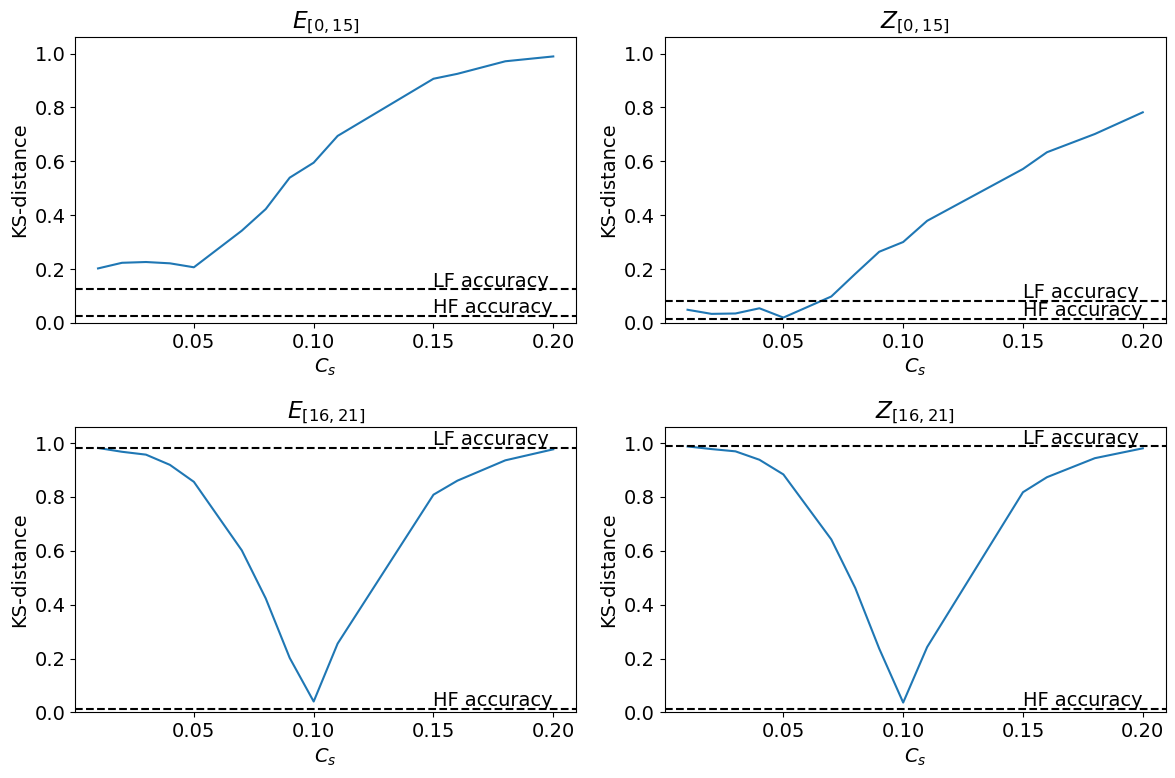

In [22]:
# Plot the performance of LF simulations with Smagorinsky parametrization
titles = ['$E_{[0,15]}$','$Z_{[0,15]}$','$E_{[16,21]}$','$Z_{[16,21]}$']
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots(2,2)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ks_list = ["ks_0", "ks_1", "ks_2", "ks_3"]
s_i = 0
dd = df[(df['method']=="Smag")].copy()
for i in [0,1,2,3]:
    dd.plot(x= 'c_s',y=ks_list[i], ax=ax[i//2,i%2], legend=False)
    ax[i//2,i%2].set_xlabel("")
 

s_i+=1


s_i+=1

LES_vals = list(df.iloc[0][["ks_0","ks_1","ks_2","ks_3"]])

for i in [0,1,2,3]:
    ax[i//2,i%2].set_title(titles[i])
    ax[i//2,i%2].set_xlabel("$C_s$")
    ax[i//2,i%2].set_ylabel("KS-distance")
    #ax[i//2,i%2].set_xscale('log')
    #tl = [100,200,400, 600, 800, 1000, 2000, 3000]
    
    #ax[i//2,i%2].set_xticks(tl, labels=tl, rotation = 45)
    #if i==0: ax[i//2,i%2].set_ylim([0,0.3]) 
    #elif i==1: ax[i//2,i%2].set_ylim([0,0.5])
    #else: ax[i//2,i%2].set_ylim([0,0.5])
    ax[i//2,i%2].axhline(y=LES_vals[i], color='black', linestyle='--')
    ax[i//2,i%2].axhline(y=DNS_vals[i], color='black', linestyle='--')
    ax[i//2,i%2].annotate('LF accuracy', xy=(0.15, LES_vals[i]+0.01), color='black')
    ax[i//2,i%2].annotate('HF accuracy', xy=(0.15, DNS_vals[i]+0.01), color='black')
    
    ax[i//2,i%2].set_ylim([0,1.06])
    #ax[i//2,i%2].set_rasterized(True)

plt.tight_layout()
#plt.savefig('figs/KS_online_smag.pdf', bbox_inches='tight')


## Investigate best performing surrogates

From the plots above we conclude that the data driven SGS perform optimal when trained on 3000 days. In the following we compare 
- the TO method with resampling trained on 3000 days
- the CNN method with Gaussian filter trained on 1000 days
- the smagorinsky parametrizations with C_s=0.1

In [27]:
df_compare = df[((df['method']=='none') |
                ((df['method']=="Smag") & (df['c_s']==0.1)) |
                ((df['method']=="CNN") & (df["filter"]=="gauss") & (df['train_length']==1000)) |
                ((df['method']=="TO") & (df["sampling_approach"] == "MVG") & (df['train_length']==3000)))
                ].copy()
df_compare["sum"] = df_compare["ks_0"] + df_compare["ks_1"] + df_compare["ks_2"] + df_compare["ks_3"]

df_compare.head(30)

,method,filter,train_length,sampling_approach,c_s,SGS_discr,test_corr,run,ks_0,ks_1,ks_2,ks_3,sum
0,none,sharp,NaN,NaN,NaN,NaN,NaN,NaN,0.124180,0.082257,0.983405,0.988315,2.178157
9,Smag,sharp,NaN,NaN,0.1,1,NaN,NaN,0.595005,0.300403,0.040459,0.036583,0.972450
85,TO,sharp,3000,MVG,NaN,NaN,NaN,1,0.076331,0.054470,0.069416,0.074621,0.274838
86,TO,sharp,3000,MVG,NaN,NaN,NaN,2,0.133957,0.089559,0.093531,0.097706,0.414753
87,TO,sharp,3000,MVG,NaN,NaN,NaN,3,0.075019,0.074796,0.069757,0.074666,0.294238
88,TO,sharp,3000,MVG,NaN,NaN,NaN,4,0.073345,0.076147,0.068087,0.073646,0.291225
89,TO,sharp,3000,MVG,NaN,NaN,NaN,5,0.049051,0.040503,0.077006,0.079826,0.246386
90,TO,sharp,3000,MVG,NaN,NaN,NaN,6,0.028356,0.058210,0.082421,0.087906,0.256893
91,TO,sharp,3000,MVG,NaN,NaN,NaN,7,0.052652,0.019854,0.057297,0.063082,0.192885
92,TO,sharp,3000,MVG,NaN,NaN,NaN,8,0.021001,0.024511,0.067212,0.073887,0.186610


### compare the summed KS-distance for the different parametrizations

c:\Users\rik\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


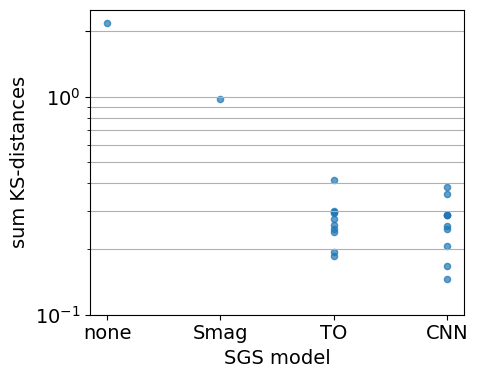

In [28]:
# compare the summed KS-distance for the different parametrizations
plt.rcParams['figure.figsize'] = [5, 4]
plt.rcParams.update({'font.size': 14})
df_compare.rename(columns={"method": "SGS model"}, inplace=True)
df_compare.plot.scatter(x='SGS model', y='sum', alpha=0.7)
plt.ylabel("sum KS-distances")
plt.yscale('log')
plt.yticks([0.1, 1,2])
plt.grid(which='both', axis='y')

plt.tight_layout()
#plt.savefig('figs/compare_sum_KS_CNN1000.pdf', bbox_inches='tight')

### Plot probability density estimates of best performing parameterizations

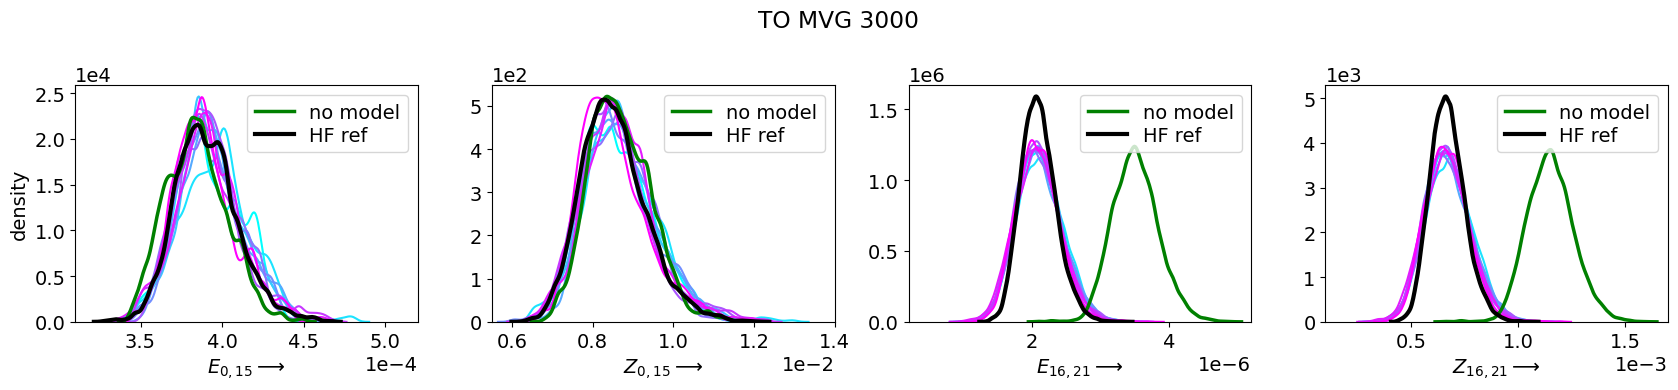

In [32]:
titles = ['$E_{0,15} \longrightarrow$','$Z_{0,15} \longrightarrow$','$E_{16,21} \longrightarrow$','$Z_{16,21} \longrightarrow$']
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (17,4)
bw=1
sampling_approach = "MVG"
train_len = 3000
ID= "TO_"+str(sampling_approach)+'_'+str(train_len)

colors = plt.cm.cool(np.linspace(0,1,10))
lims = [[0.00031,0.00052],[0.0055,0.014],[0.0000002,0.0000052],[0.0001,0.0017]]

for run in range(0,10):
    file_name = './pre_computed_data/samples/gridsearch/'+ID+'_run_'+str(run+1)+'_t_5000.0.hdf5'
    with h5py.File(file_name) as file:
        data = file["Q_LF"][:-1,:]
    for qoi in [0,1,2,3]:
        plt.subplot(1,4,qoi+1)
        sns.kdeplot(data[:,qoi], color = colors[run])

# LF
with h5py.File("output/samples/LF_rk4_t_5000.0.hdf5") as file_LF:
    LFdata = file_LF["Q_LF"][:-1,:]

for i in [0,1,2,3]:

    plt.subplot(1,4,i+1)
    sns.kdeplot(LFdata[:,i], color='green', linewidth=2.5, label="no model")
    
    

#HF

with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file_ref:
    refdata = file_ref["Q_HF"][:-1,:]
    
for i in [0,1,2,3]:

    plt.subplot(1,4,i+1)
    sns.kdeplot(refdata[:,i], color='black', linewidth=3, label="HF ref")
    plt.legend(labelspacing = 0.2)
    plt.ticklabel_format(axis="both",style='sci',scilimits=(0,0),useMathText=False)
    plt.xlabel(titles[i])
    plt.xlim(lims[i])
    if i==0: plt.ylabel("density")
    else: plt.ylabel("")


# smag
# for i in [0,1,2,3]:

#     plt.subplot(1,4,i+1)
#     sns.kdeplot(file_smag["Q_LF"][:500000,i], color='green', linewidth=2.5, label="Smag")
    
plt.suptitle("TO MVG 3000")
plt.tight_layout()

#plt.savefig('figs/TO_resample_600_pdfs_with_LF.pdf', bbox_inches='tight')

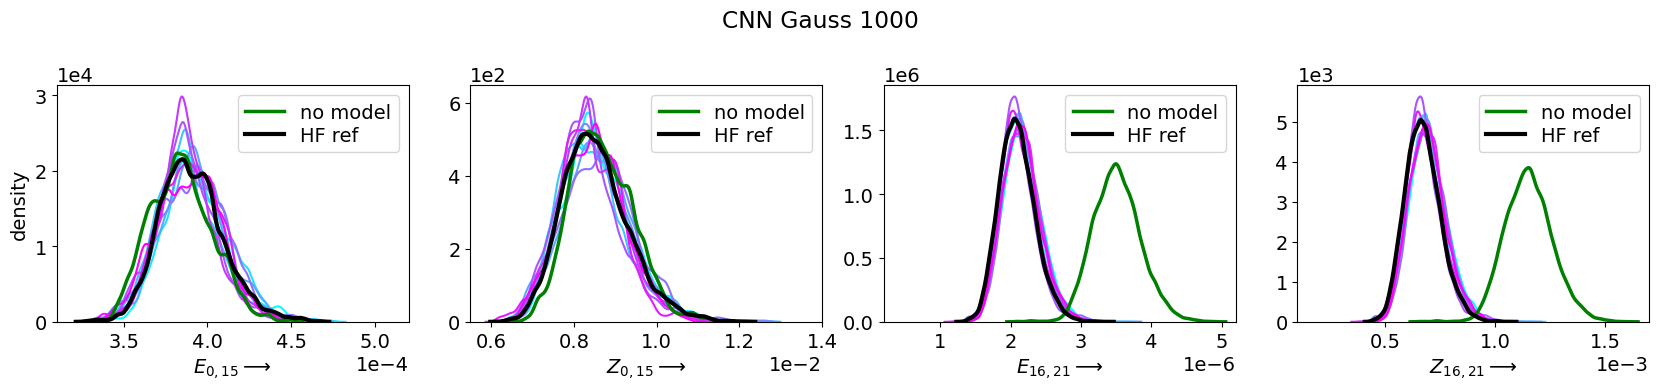

In [33]:
titles = ['$E_{0,15} \longrightarrow$','$Z_{0,15} \longrightarrow$','$E_{16,21} \longrightarrow$','$Z_{16,21} \longrightarrow$']
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (17,4)
bw=1
filter = "gauss"
train_len = 1000
ID= "CNN_"+str(filter)+'_'+str(train_len)

colors = plt.cm.cool(np.linspace(0,1,10))
lims = [[0.00031,0.00052],[0.0055,0.014],[0.0000002,0.0000052],[0.0001,0.0017]]

for run in range(0,10):
    file_name = './pre_computed_data/samples/gridsearch/'+ID+'_run_'+str(run+1)+'_t_5000.0.hdf5'
    with h5py.File(file_name) as file:
        data = file["Q_LF"][:-1,:]
    for qoi in [0,1,2,3]:
        plt.subplot(1,4,qoi+1)
        sns.kdeplot(data[:,qoi], color = colors[run])

# LF
with h5py.File("output/samples/LF_rk4_t_5000.0.hdf5") as file_LF:
    LFdata = file_LF["Q_LF"][:-1,:]

for i in [0,1,2,3]:

    plt.subplot(1,4,i+1)
    sns.kdeplot(LFdata[:,i], color='green', linewidth=2.5, label="no model")
    

#HF

with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file_ref:
    refdata = file_ref["Q_HF"][:-1,:]
    
for i in [0,1,2,3]:

    plt.subplot(1,4,i+1)
    sns.kdeplot(refdata[:,i], color='black', linewidth=3, label="HF ref")
    plt.legend(labelspacing = 0.2)
    plt.ticklabel_format(axis="both",style='sci',scilimits=(0,0),useMathText=False)
    plt.xlabel(titles[i])
    plt.xlim(lims[i])
    if i==0: plt.ylabel("density")
    else: plt.ylabel("")


# smag
# for i in [0,1,2,3]:

#     plt.subplot(1,4,i+1)
#     sns.kdeplot(file_smag["Q_LF"][:500000,i], color='green', linewidth=2.5, label="Smag")
    
plt.suptitle("CNN Gauss 1000")  
plt.tight_layout()

#plt.savefig('figs/CNN_1000_pdfs_with_LF.pdf', bbox_inches='tight')

## Solutions in depth
In the following section we explore the solutions of the best performing setups in more depth. We look at 
- the energy spectra of the solutions;
- the decorrelation time and
- plots of the vorticity field.

In [34]:

from aux_code.filters import Grids
from aux_code.read_inputs import adapt_input_file

def calc_correlation(w1,w2):
    w1 = w1 - np.mean(w1)
    w2 = w2 - np.mean(w2)
    return np.mean(w1*w2)/(np.sqrt(np.mean(w1**2))*np.sqrt(np.mean(w2**2)))

def get_psi(w_hat,N=65):
    l = np.fft.fftfreq(N)*N   # in y-direction
    kx = 1j * l.reshape(1,N)
    ky = 1j * l.reshape(N,1)

    k_squared = kx**2+ky**2
    k_squared_no_zero = k_squared.copy()
    k_squared_no_zero[0,0] = 1.0

    if len(w_hat.shape) == 2:
        psi_hat = w_hat / k_squared_no_zero
        psi_hat[0,0] = 0
    else:
        psi_hat = w_hat / k_squared_no_zero.reshape(1,N,N)
        psi_hat[:,0,0] = 0
    
    return psi_hat

def calc_spec(w_hat, N):
    l = np.fft.fftfreq(N)*N  
    kx = l.reshape(1,N)
    ky = l.reshape(N,1)

    psi_hat = get_psi(w_hat, N=N)
    E_k = (-0.5*(psi_hat*np.conj(w_hat))/N**4).real
    if len(w_hat.shape) == 3:
        E_k = np.mean(E_k, axis=0)

    a = 0.5
    n = N//2
    #n = int(np.log(np.sqrt(2)*(N//2))/np.log(a))+2
    spec = np.zeros(n)
    #k = a**np.arange(n)
    k = np.arange(n)
    for i in range(len(k)):
        #mask = ((kx**2+ky**2 < (k[i]+0.5)**2) & (kx**2+ky**2 >= (k[i]-0.5)**2))
        mask = ((kx**2+ky**2 < (k[i]+a)**2) & (kx**2+ky**2 >= (k[i]-a)**2))
        spec[i] = np.sum(E_k[mask])
        
    spec[0] = E_k[0,0]
    return spec

In [35]:
grid = Grids(N_LF=65, N_HF=65, N_LF_resolved=65, N_HF_resolved=65)
gaussian_filter = np.exp(grid.k_squared_LF*(2*grid.dx_les)**2/24)

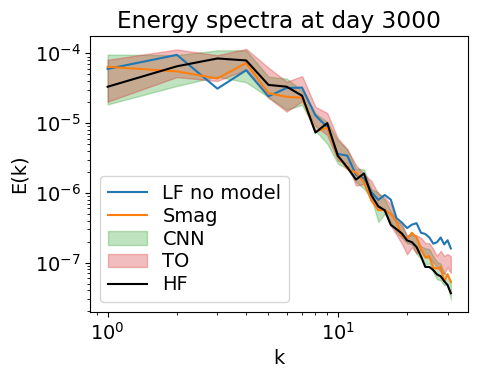

In [36]:
# plot spectra at specified day:
day = 3000

# HF 
with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file_ref:
    ref_field  =  file_ref["w_hat_n_HF_filtered"][day//100,:,:]
ref_spec = calc_spec(ref_field, 65)

# LF
with h5py.File("pre_computed_data/samples/LF_rk4_t_5000.0.hdf5") as file_LF:
    LF_field = file_LF["w_hat_n_LF"][day//10,:,:]
LF_spec = calc_spec(LF_field, 65)

# Smag
with h5py.File("pre_computed_data/samples/gridsearch/Cs_0.1_t_5000.0.hdf5") as file_smag:
    smag_field = file_smag["w_hat_n_LF"][day//10,:,:]
smag_spec = calc_spec(smag_field, 65)

# CNN
cnn_spec = np.zeros((2,32))
cnn_spec[1,:] = 100
for run in range(1,11):
    with h5py.File(f"pre_computed_data/samples/gridsearch/CNN_gauss_1000_run_{run}_t_5000.0.hdf5") as file:
        cnn_field = file["w_hat_n_LF"][day//10,:,:]/gaussian_filter
    cnn_spec[0,:] = np.maximum(calc_spec(cnn_field, 65), cnn_spec[0,:])
    cnn_spec[1,:] = np.minimum(calc_spec(cnn_field, 65), cnn_spec[1,:])

# TO
to_spec = np.zeros((2,32))
to_spec[1,:] = 100
for run in range(1,11):
    with h5py.File(f"pre_computed_data/samples/gridsearch/TO_MVG_3000_run_{run}_t_5000.0.hdf5") as file:
        to_field = file["w_hat_n_LF"][day//10,:,:]
    to_spec[0,:] = np.maximum(calc_spec(to_field, 65), to_spec[0,:])
    to_spec[1,:] = np.minimum(calc_spec(to_field, 65), to_spec[1,:])

# make the figure
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (5,4)
fig, ax = plt.subplots(1,1)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
k = np.arange(1,32,1)
ax.plot(k,LF_spec[1:], label="LF no model")
ax.plot(k,smag_spec[1:], label="Smag")
ax.fill_between(k,cnn_spec[0,1:], cnn_spec[1,1:], color=prop_cycle[2],  alpha=0.3, label="CNN")
ax.fill_between(k,to_spec[0,1:],to_spec[1,1:], color=prop_cycle[3], alpha=0.3, label="TO")
ax.plot(k,ref_spec[1:], label="HF", color='black')

ax.set_xlabel("k")
ax.set_ylabel("E(k)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left', labelspacing = 0.2)
ax.set_title(f"Energy spectra at day {day}")
plt.tight_layout()


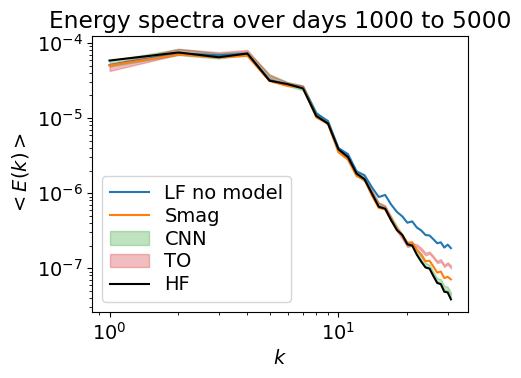

In [37]:
# plot spectra averaged over range of days:
days = [1000, 5000]

# HF 
with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file_ref:
    ref_field  =  file_ref["w_hat_n_HF_filtered"][days[0]//100:days[1]//100+1,:,:]
ref_spec = calc_spec(ref_field, 65)

# LF
with h5py.File("pre_computed_data/samples/LF_rk4_t_5000.0.hdf5") as file_LF:
    LF_field = file_LF["w_hat_n_LF"][days[0]//10:days[1]//10+1:10,:,:]
LF_spec = calc_spec(LF_field, 65)

# Smag
with h5py.File("pre_computed_data/samples/gridsearch/Cs_0.1_t_5000.0.hdf5") as file_smag:
    smag_field = file_smag["w_hat_n_LF"][days[0]//10:days[1]//10+1:10,:,:]
smag_spec = calc_spec(smag_field, 65)

# CNN
cnn_spec = np.zeros((2,32))
cnn_spec[1,:] = 100
for run in range(1,11):
    with h5py.File(f"pre_computed_data/samples/gridsearch/CNN_gauss_1000_run_{run}_t_5000.0.hdf5") as file:
        cnn_field = file["w_hat_n_LF"][days[0]//10:days[1]//10+1:10,:,:]/gaussian_filter
    cnn_spec[0,:] = np.maximum(calc_spec(cnn_field, 65), cnn_spec[0,:])
    cnn_spec[1,:] = np.minimum(calc_spec(cnn_field, 65), cnn_spec[1,:])

# TO
to_spec = np.zeros((2,32))
to_spec[1,:] = 100
for run in range(1,11):
    with h5py.File(f"pre_computed_data/samples/gridsearch/TO_MVG_3000_run_{run}_t_5000.0.hdf5") as file:
        to_field = file["w_hat_n_LF"][days[0]//10:days[1]//10+1:10,:,:]
    to_spec[0,:] = np.maximum(calc_spec(to_field, 65), to_spec[0,:])
    to_spec[1,:] = np.minimum(calc_spec(to_field, 65), to_spec[1,:])

# make the figure
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (5,4)
fig, ax = plt.subplots(1,1)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
k = np.arange(1,32,1)
ax.plot(k,LF_spec[1:], label="LF no model")
ax.plot(k,smag_spec[1:], label="Smag")
ax.fill_between(k,cnn_spec[0,1:], cnn_spec[1,1:], color=prop_cycle[2],  alpha=0.3, label="CNN")
ax.fill_between(k,to_spec[0,1:],to_spec[1,1:], color=prop_cycle[3], alpha=0.3, label="TO")
ax.plot(k,ref_spec[1:], label="HF", color='black')

ax.set_xlabel("$k$")
ax.set_ylabel("$<E(k)>$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left', labelspacing = 0.2)
plt.tight_layout()
#plt.savefig('figs/energy_spectra_1000_5000.pdf', bbox_inches='tight')

ax.set_title(f"Energy spectra over days {days[0]} to {days[1]}")
plt.tight_layout()

In [45]:
# plot decay of correlation over time
# The results file of the reference simulation only contains the solution every 100th day, we need a higher rate for this so we run a new short simulation
adapt_input_file("inputs/in_get_training_data.json", "inputs/in_HF_short.json", {"sim_ID":"HF_short","simulation_time":150, "store_frame_rate":10, "create_training_data":False})
if not SKIP_SOLVERS:
    os.system("python compute_reference.py inputs/in_HF_short.json")

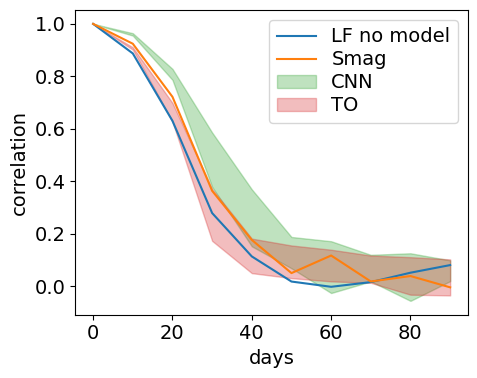

In [38]:
ndays = 100
# HF
with h5py.File("pre_computed_data/samples/HF_short_t_150.0.hdf5") as file_ref:
    ref_fields  =  file_ref["w_hat_n_HF_filtered"][:,:,:]

# LF
corr_LF = np.zeros(ndays//10)
with h5py.File("pre_computed_data/samples/LF_rk4_t_5000.0.hdf5") as file_LF:
    for i in range(len(corr_LF)):
        corr_LF[i] = calc_correlation(np.fft.ifft2(file_LF["w_hat_n_LF"][i,:,:]).real,np.fft.ifft2(ref_fields[i,:,:]).real)

# Smag
corr_Smag = np.zeros(ndays//10)
with h5py.File("pre_computed_data/samples/gridsearch/Cs_0.1_t_5000.0.hdf5") as file_smag:
    for i in range(len(corr_Smag)):
        corr_Smag[i] = calc_correlation(np.fft.ifft2(file_smag["w_hat_n_LF"][i,:,:]).real,np.fft.ifft2(ref_fields[i,:,:]).real)

# CNN
corr_CNN = np.zeros((2,ndays//10))
corr_CNN[1,:] = 1
for run in range(1,11):
    with h5py.File(f"pre_computed_data/samples/gridsearch/CNN_gauss_1000_run_{run}_t_5000.0.hdf5") as file:
        for i in range(len(corr_CNN[0,:])):
            corr = calc_correlation(np.fft.ifft2(file["w_hat_n_LF"][i,:,:]/gaussian_filter).real,np.fft.ifft2(ref_fields[i,:,:]).real)
            corr_CNN[0,i] = max(corr, corr_CNN[0,i])
            corr_CNN[1,i] = min(corr, corr_CNN[1,i])

# TO
corr_TO = np.zeros((2,ndays//10))
corr_TO[1,:] = 1
for run in range(1,11):
    with h5py.File(f"pre_computed_data/samples/gridsearch/TO_MVG_3000_run_{run}_t_5000.0.hdf5") as file:
        for i in range(len(corr_TO[0,:])):
            corr = calc_correlation(np.fft.ifft2(file["w_hat_n_LF"][i,:,:]).real,np.fft.ifft2(ref_fields[i,:,:]).real)
            corr_TO[0,i] = max(corr, corr_TO[0,i])
            corr_TO[1,i] = min(corr, corr_TO[1,i])

# make the figure
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (5,4)
fig, ax = plt.subplots(1,1)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
days = np.arange(0,ndays,10)
ax.plot(days,corr_LF, label="LF no model")
ax.plot(days,corr_Smag, label="Smag")
ax.fill_between(days, corr_CNN[1,:], corr_CNN[0,:], color=prop_cycle[2],  alpha=0.3, label="CNN")
ax.fill_between(days, corr_TO[1,:], corr_TO[0,:], color=prop_cycle[3], alpha=0.3, label="TO")
ax.set_xlabel("days")
ax.set_ylabel("correlation")
ax.legend(loc='upper right', labelspacing = 0.2)
plt.tight_layout()
#plt.savefig('figs/correlations.pdf', bbox_inches='tight')

In [39]:
# we plot the final fields of the best runs
# first we need to identify the best runs based on lowest KS-distance
df_cnn_gauss_1000 = df[(df['method']=="CNN") & (df["filter"]=="gauss") & (df['train_length']==1000)].copy()
df_cnn_gauss_1000['sum'] = df_cnn_gauss_1000['ks_0'] + df_cnn_gauss_1000['ks_1'] + df_cnn_gauss_1000['ks_2'] + df_cnn_gauss_1000['ks_3']
best_cnn_run = int(df_cnn_gauss_1000.loc[df_cnn_gauss_1000['sum'].idxmin()]["run"])

df_to_MVG_3000 = df[(df['method']=="TO") & (df["sampling_approach"]=="resample") & (df['train_length']==600)].copy()
df_to_MVG_3000['sum'] = df_to_MVG_3000['ks_0'] + df_to_MVG_3000['ks_1'] + df_to_MVG_3000['ks_2'] + df_to_MVG_3000['ks_3']
best_TO_run = int(df_to_MVG_3000.loc[df_to_MVG_3000['sum'].idxmin()]["run"])

# read the final fields from files
with h5py.File(f"pre_computed_data/samples/gridsearch/CNN_gauss_1000_run_{best_cnn_run}_t_5000.0.hdf5") as file:
    cnn_field = file["w_hat_n_LF"][500,:,:]/gaussian_filter
with h5py.File(f"pre_computed_data/samples/gridsearch/TO_MVG_3000_run_{best_TO_run}_t_5000.0.hdf5") as file:
    to_field = file["w_hat_n_LF"][500,:,:]
with h5py.File("pre_computed_data/samples/LF_rk4_t_5000.0.hdf5") as file_LF:
    LF_field = file_LF["w_hat_n_LF"][500,:,:]
with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file_ref:
    ref_field = file_ref["w_hat_n_HF_filtered"][50,:,:]
with h5py.File("pre_computed_data/samples/gridsearch/Cs_0.1_t_5000.0.hdf5") as file_smag:
    smag_field = file_smag["w_hat_n_LF"][500,:,:]


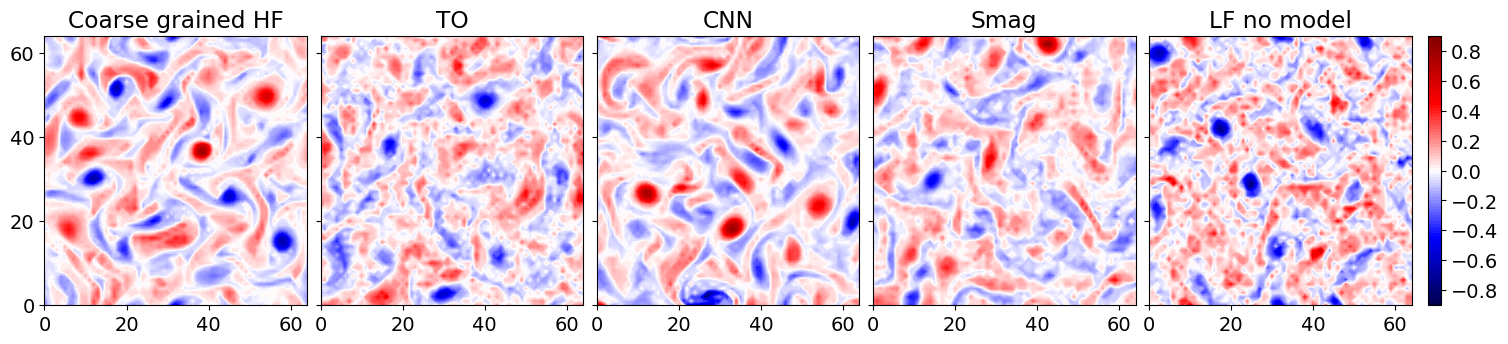

In [40]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (21,3.5)
plt.rcParams['image.cmap'] = 'seismic'

fig, ax = plt.subplots(1,5, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0.05})
levels = np.linspace(-0.9,0.9,91)
cb = ax[0].contourf(np.fft.ifft2(ref_field).real, levels=levels)
ax[1].contourf(np.fft.ifft2(to_field).real, levels=levels)
ax[2].contourf(np.fft.ifft2(cnn_field).real, levels=levels)
ax[3].contourf(np.fft.ifft2(smag_field).real, levels=levels)
ax[4].contourf(np.fft.ifft2(LF_field).real, levels=levels)
fig.colorbar(cb, ax=ax.ravel().tolist(), pad=0.01)
titles = ["Coarse grained HF", "TO", "CNN", "Smag", "LF no model"]
for i in [0,1,2,3,4]:
    ax[i].set_title(titles[i])

#plt.savefig("figs/final_fields.png", dpi=700, bbox_inches='tight')

In [41]:
# we plot the final fields of the worst runs
# first we need to identify the worst runs based on lowest KS-distance
df_cnn_gauss_1000 = df[(df['method']=="CNN") & (df["filter"]=="gauss") & (df['train_length']==1000)].copy()
df_cnn_gauss_1000['sum'] = df_cnn_gauss_1000['ks_0'] + df_cnn_gauss_1000['ks_1'] + df_cnn_gauss_1000['ks_2'] + df_cnn_gauss_1000['ks_3']
best_cnn_run = int(df_cnn_gauss_1000.loc[df_cnn_gauss_1000['sum'].idxmax()]["run"])

df_to_MVG_3000 = df[(df['method']=="TO") & (df["sampling_approach"]=="resample") & (df['train_length']==600)].copy()
df_to_MVG_3000['sum'] = df_to_MVG_3000['ks_0'] + df_to_MVG_3000['ks_1'] + df_to_MVG_3000['ks_2'] + df_to_MVG_3000['ks_3']
best_TO_run = int(df_to_MVG_3000.loc[df_to_MVG_3000['sum'].idxmax()]["run"])

# read the final fields from files
with h5py.File(f"pre_computed_data/samples/gridsearch/CNN_gauss_1000_run_{best_cnn_run}_t_5000.0.hdf5") as file:
    cnn_field = file["w_hat_n_LF"][500,:,:]/gaussian_filter
with h5py.File(f"pre_computed_data/samples/gridsearch/TO_MVG_3000_run_{best_TO_run}_t_5000.0.hdf5") as file:
    to_field = file["w_hat_n_LF"][500,:,:]
with h5py.File("pre_computed_data/samples/LF_rk4_t_5000.0.hdf5") as file_LF:
    LF_field = file_LF["w_hat_n_LF"][500,:,:]
with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file_ref:
    ref_field = file_ref["w_hat_n_HF_filtered"][50,:,:]
with h5py.File("pre_computed_data/samples/gridsearch/Cs_0.1_t_5000.0.hdf5") as file_smag:
    smag_field = file_smag["w_hat_n_LF"][500,:,:]

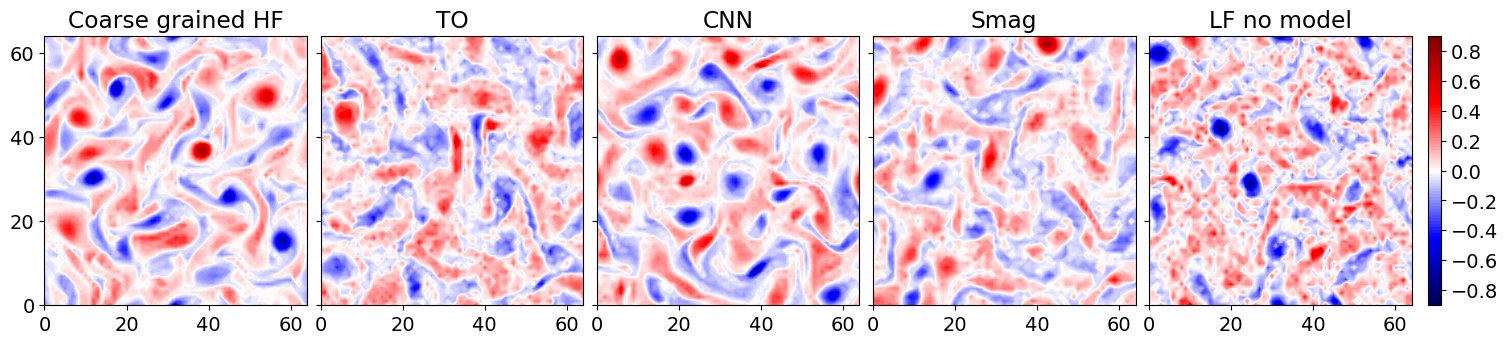

In [42]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (21,3.5)
plt.rcParams['image.cmap'] = 'seismic'

fig, ax = plt.subplots(1,5, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0.05})
levels = np.linspace(-0.9,0.9,91)
cb = ax[0].contourf(np.fft.ifft2(ref_field).real, levels=levels)
ax[1].contourf(np.fft.ifft2(to_field).real, levels=levels)
ax[2].contourf(np.fft.ifft2(cnn_field).real, levels=levels)
ax[3].contourf(np.fft.ifft2(smag_field).real, levels=levels)
ax[4].contourf(np.fft.ifft2(LF_field).real, levels=levels)
fig.colorbar(cb, ax=ax.ravel().tolist(), pad=0.01)
titles = ["Coarse grained HF", "TO", "CNN", "Smag", "LF no model"]
for i in [0,1,2,3,4]:
    ax[i].set_title(titles[i])

#plt.savefig("../results_paper/final_fields.png", dpi=700, bbox_inches='tight')

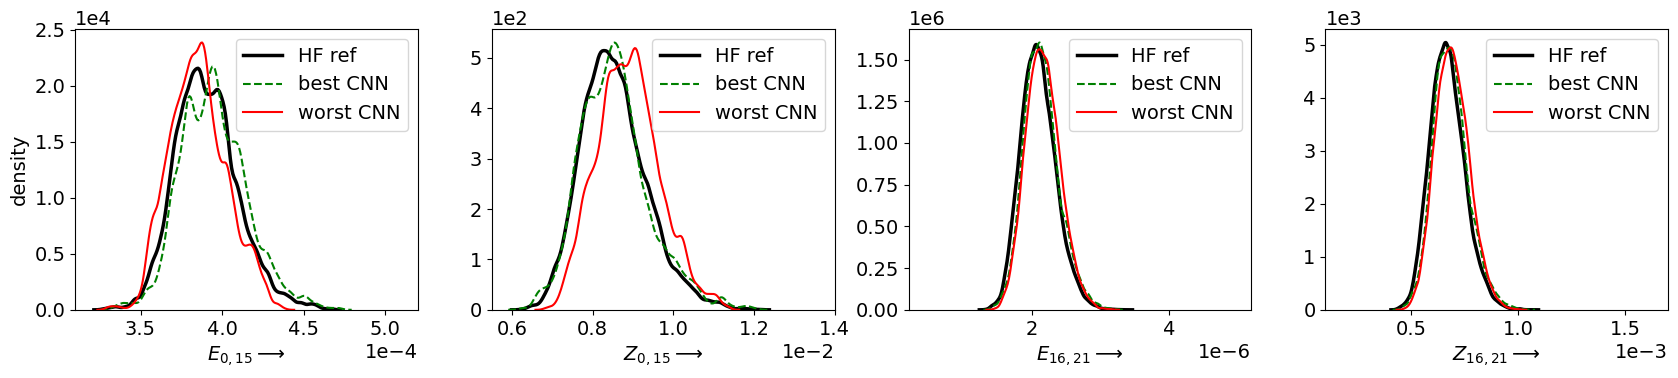

In [51]:
#Finally to illustrate what goes wrong in the simualtions with the CNN with sharp filter 
# we plot the QoI distributions of the best and worst run trained on 3000 days

df_cnn_sharp_3000 = df[(df['method']=="CNN") & (df["filter"]=="sharp") & (df['train_length']==3000)].copy()
df_cnn_sharp_3000['sum'] = df_cnn_sharp_3000['ks_0'] + df_cnn_sharp_3000['ks_1'] + df_cnn_sharp_3000['ks_2'] + df_cnn_sharp_3000['ks_3']
best_cnn_run = int(df_cnn_sharp_3000.loc[df_cnn_sharp_3000['sum'].idxmin()]["run"])
worst_cnn_run = int(df_cnn_sharp_3000.loc[df_cnn_sharp_3000['sum'].idxmax()]["run"])
# read data from files
with h5py.File(f"pre_computed_data/samples/gridsearch/CNN_sharp_3000_run_{best_cnn_run}_t_5000.0.hdf5") as file:
    cnn_Q_best = file["Q_LF"][:-1,:]
with h5py.File(f"pre_computed_data/samples/gridsearch/CNN_sharp_3000_run_{worst_cnn_run}_t_5000.0.hdf5") as file:
    cnn_Q_worst = file["Q_LF"][:-1,:]
# ref
with h5py.File("pre_computed_data/ref/HF_20000days_RK4.hdf5") as file_ref:
    ref_Q = file_ref["Q_HF"][:-1,:]

titles = ['$E_{0,15} \longrightarrow$','$Z_{0,15} \longrightarrow$','$E_{16,21} \longrightarrow$','$Z_{16,21} \longrightarrow$']
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (17,4)
lims = [[0.00031,0.00052],[0.0055,0.014],[0.0000002,0.0000052],[0.0001,0.0017]]
for i in [0,1,2,3]:

    plt.subplot(1,4,i+1)
    sns.kdeplot(ref_Q[:,i], color='black', linewidth=2.5, label="HF ref")
    sns.kdeplot(cnn_Q_best[:,i],linestyle='--', color='green', linewidth=1.5, label="best CNN")
    sns.kdeplot(cnn_Q_worst[:,i], color='red', linewidth=1.5, label="worst CNN")
    plt.ticklabel_format(axis="both",style='sci',scilimits=(0,0),useMathText=False)
    plt.xlabel(titles[i])
    plt.xlim(lims[i])
    plt.legend()
    if i==0: plt.ylabel("density")
    else: plt.ylabel("")
plt.tight_layout()
#plt.savefig('figs/CNN_3000_best_worst.pdf', bbox_inches='tight')
